## Import Statements

In [1]:
from qiskit import *
from qiskit import Aer
from qiskit.circuit.library.standard_gates import HGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.circuit import Parameter
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
simulator = Aer.get_backend('statevector_simulator')
from qiskit import IBMQ, assemble, transpile
import qiskit.quantum_info as qi
import scipy

provider = IBMQ.load_account()
provider.backends(simulator=False, operational=True)
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
small_devices
print(provider.backends(simulator=True, operational=True))

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>]


## Function Definitions

In [71]:
def Fgate(k,N, dagger = False):
    qcirc = QuantumCircuit(2,name="F_{:}".format(k))
    qcirc.rz(2*np.pi*k/N,1)
    qcirc.cx(1,0)
    qcirc.ch(0,1)
    qcirc.cx(1,0)
    qcirc.cz(1,0)

    if(dagger):
        return(qcirc.decompose().inverse())

    return(qcirc.decompose())

def fSWAP():
    qcirc = QuantumCircuit(2,name="fSWAP")
    qcirc.cx(0,1)
    qcirc.cx(1,0)
    qcirc.cx(0,1)
    qcirc.h(1)
    qcirc.cx(0,1)
    qcirc.h(1)
    return(qcirc.decompose())

# fSWAP = ["s",q1,q2]
# F-Gate = ["f",q1,q2,k]
# Fdagger-Gate = ["fd",q1,q2,k]
# B-Gate = ["b",q1,q2,k,m]
# Bdagger-Gate = ["b",q1,q2,k,m]
def listAppend(orderedlist,qc):
    N = len(qc.qubits)
    for i in orderedlist:
        if(i[0] == "s" and len(i) == 3):
            qc.append(fSWAP().decompose(),[i[1],i[2]])
        elif(i[0] == "f" and len(i) == 4):
            qc.append(Fgate(i[3],N,False).decompose(),[i[1],i[2]])
        elif(i[0] == "fd" and len(i) == 4):
            qc.append(Fgate(i[3],N,True).decompose(),[i[1],i[2]])
        elif(i[0] == "b" and len(i) == 5):
            qc.append(bogT(i[3],N,m,False).decompose(),[i[1],i[2]])
        elif(i[0] == "bd" and len(i) == 5):
            qc.append(bogT(i[3],N,m,True).decompose(),[i[1],i[2]])
        else:
            print("Failed circuit instruction: {:}".format(i))

## Implements exp( -i/2*(thetax XX + thetay YY + thetaz ZZ))
def pauliExp(thetax = 0,thetay = 0,thetaz = 0):
    qcirc = QuantumCircuit(2,name="XX: {:}, YY: {:}, ZZ: {:}".format(thetax,thetay,thetaz))
    qcirc.cx(0,1)
    if(thetax != 0):
        qcirc.rx(thetax,0)
    if(thetaz != 0):
        qcirc.rz(thetaz,1)
    qcirc.h(0)
    qcirc.cx(0,1)
    if(thetaz != 0):
        qcirc.rz(-thetay,1)
    qcirc.s(0)
    qcirc.h(0)
    qcirc.cx(0,1)
    qcirc.rx(-np.pi/2,0)
    qcirc.rx(np.pi/2,1)
    return(qcirc.decompose())

    ### Bogoliubov Transform B-Gate
def Bgate(q,N,m, dagger = False):
    alpha = -2.0*np.pi*q/N
    omega = np.sqrt(m**2 + np.cos(-alpha)**2)
    beta = np.arctan( np.sqrt( (omega-m)/(omega+m) ) )
    theta2 = -alpha - np.pi/2
    theta3 = alpha/2
    theta4 = beta
    theta5 = -alpha/2
    theta6 = 1/2*(np.pi - alpha)
    qcirc = QuantumCircuit(2,name="B")
    qcirc.rz(theta6,0)
    qcirc.rz(theta5,1)
    qcirc.append(pauliExp(theta4,theta4,theta3).decompose(),[0,1])
    qcirc.rz(theta2,1)

    if(dagger):
        return(qcirc.decompose().inverse())

    return(qcirc.decompose())

    ### Decomposition of Controlled RZ for plotting
def CRZD(theta,control_qubit,target_qubit,circuit):
    circuit.rz(theta/2,target_qubit)
    circuit.cx(control_qubit,target_qubit)
    circuit.rz(-theta/2,target_qubit)
    circuit.cx(control_qubit,target_qubit)

In [73]:
def chunks(lst, n):
    ### Yield successive n-sized chunks from lst.
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def swapladder(qubits,dagger = False):
    N = len(qubits)
    qcirc = QuantumCircuit(N,name="SwapLadder({:})".format(N))
    for i in range(int(N/2)-1):
        orderedlist = []
        for k in range(i+1):
            orderedlist = orderedlist + [["s",int(N/2) - 1 + i - 2*k,int(N/2) + i - 2*k]]
        listAppend(orderedlist,qcirc)
    if(dagger):
        return(qcirc.decompose().inverse())

    return(qcirc.decompose())

    ### Fermionic Fast Fourier Transform
def FFFT(qubits,dagger = False):
    qubits = [i - qubits[0] for i in qubits]
    N = len(qubits)
    qpairs = [[int(2*a),int(2*a+1)] for a in range(int(N/2))]
    qcirc = QuantumCircuit(N)
    logN = int(np.log2(N))
    modulus = int(N/2)
    lengthlist = [int(2**i) for i in range(logN,0,-1)]
    iterlist = [int(2**i) for i in range(logN)]
    for k in range(logN):
        ### Subsets for swapladders
        subsets = list(chunks(qubits,lengthlist[k]))

        ### Swapladders
        if(len(subsets[0])>1):
            for i in range(len(subsets)):
                qcirc.append(swapladder(subsets[i],False).decompose(),subsets[i])

        ### Tower of F-Gates
        for j in range(len(qpairs)):
            qcirc.append(Fgate((j*iterlist[k])%modulus,N,True).decompose(),qpairs[j])
        
        ### Inverse swapladders
        if(len(subsets[0])>1):
            for i in range(len(subsets)):
                qcirc.append(swapladder(subsets[i],True).decompose(),subsets[i])
    qcirc = qcirc.decompose()
    if(dagger):
        return(qcirc.decompose().inverse())

    return(qcirc.decompose())

    ### Staggered Fermion Fast Fourier Transform
    # Assuming input is +-+-+-+-+-... Bdagger on the left before this
def SFFFT(qubits,dagger=False):
    qcirc = QuantumCircuit(len(qubits),name="U+_SFFFT")
    N = len(qubits)
    particles = qubits[:int(N/2)]
    antiparticles = qubits[int(N/2):]

    qcirc.append(swapladder(qubits),qubits)

    ### Particle FFFT
    qcirc.append(FFFT(particles),particles)

    ### Antiparticle FFFT
    qcirc.append(FFFT(antiparticles),antiparticles)

    ### Swapladder to re-arrange before Bogoliubov
    qcirc.append(swapladder(qubits,True),qubits)

    if(dagger):
        return(qcirc.decompose().inverse())

    return(qcirc.decompose())

def Bogoliubov(qubits, dagger = False):
    qubits = [i-qubits[0] for i in qubits]
    N = len(qubits)
    qcirc = QuantumCircuit(N,name="B")
    qpairs = [[int(2*a),int(2*a+1)] for a in range(int(N/2))]
    for i in range(len(qpairs)):
        qcirc.append(Bgate(i,N,1,False),qpairs[i])
    if(dagger):
        return(qcirc.inverse())

    return(qcirc)
        

## Check fFFT Gate Compositions

In [11]:
qc = QuantumCircuit(8)
qr = QuantumRegister(8)
qc.append(swapladder([0,1,2,3,4,5,6,7]),[0,1,2,3,4,5,6,7])
qc.draw()

┌────────────────┐
q_0: ┤0               ├
     │                │
q_1: ┤1               ├
     │                │
q_2: ┤2               ├
     │                │
q_3: ┤3               ├
     │  SwapLadder(8) │
q_4: ┤4               ├
     │                │
q_5: ┤5               ├
     │                │
q_6: ┤6               ├
     │                │
q_7: ┤7               ├
     └────────────────┘

In [12]:
qcirc = QuantumCircuit(4,name="U+_fFT")
list = [["fd",0,1,0],["fd",2,3,0],["s",1,2]]
listAppend(list,qcirc)
qcirc.draw()

┌───────┐          
q_0: ┤0      ├──────────
     │  F+_0 │┌────────┐
q_1: ┤1      ├┤0       ├
     ├───────┤│  fSWAP │
q_2: ┤0      ├┤1       ├
     │  F+_0 │└────────┘
q_3: ┤1      ├──────────
     └───────┘

In [15]:
qc = QuantumCircuit(8)
qr = QuantumRegister(8)
qc.append(fFT8(),[0,1,2,3,4,5,6,7])
qc.draw()

┌─────────┐
q_0: ┤0        ├
     │         │
q_1: ┤1        ├
     │         │
q_2: ┤2        ├
     │         │
q_3: ┤3        ├
     │  U+_fFT │
q_4: ┤4        ├
     │         │
q_5: ┤5        ├
     │         │
q_6: ┤6        ├
     │         │
q_7: ┤7        ├
     └─────────┘

## Circuit Diagrams for Slides

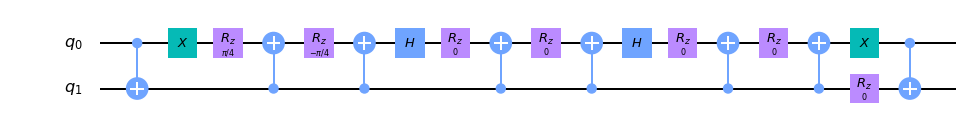

In [90]:
## OLD SCHEME FOR BOGOLIUBOV NOT OPTIMIZED
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.x(0)
CRZD(np.pi/2,1,0,qc)
qc.h(0)
CRZD(0,1,0,qc)
qc.h(0)
CRZD(0,1,0,qc)
qc.rz(0,1) #double coefficient
qc.x(0)
qc.cx(0,1)
qc.draw("mpl")

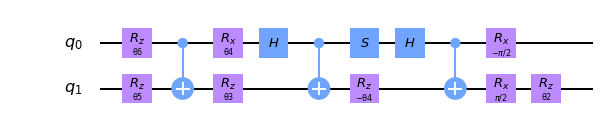

In [23]:
## OPTIMIZED BOGOLIUBOV TRANSFORM
qcirc = QuantumCircuit(2)
theta6 = Parameter('θ6')
theta5 = Parameter('θ5')
theta2 = Parameter('θ2')
theta4 = Parameter('θ4')
theta3 = Parameter('θ3')
mtheta4 = Parameter('-θ4')
qcirc.rz(theta6,0)
qcirc.rz(theta5,1)
qcirc.cx(0,1)
qcirc.rx(theta4,0)
qcirc.rz(theta3,1)
qcirc.h(0)
qcirc.cx(0,1)
qcirc.rz(mtheta4,1)
qcirc.s(0)
qcirc.h(0)
qcirc.cx(0,1)
qcirc.rx(-np.pi/2,0)
qcirc.rx(np.pi/2,1)

qcirc.rz(theta2,1)
qcirc.draw("mpl")


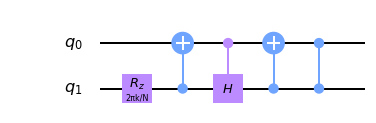

In [15]:
## TWO-POINT FFT CIRCUIT
pi2kN = Parameter("2πk/N")
qcirc=QuantumCircuit(2)
qcirc.rz(pi2kN,1)
qcirc.cx(1,0)
qcirc.ch(0,1)
qcirc.cx(1,0)
qcirc.cz(1,0)
qcirc.draw("mpl")

## MISC WORK / TESTING

In [74]:
backend_sim = Aer.get_backend('qasm_simulator')
N=4
cr = ClassicalRegister(1,'c')
qr = QuantumRegister(N,'q')
ar = QuantumRegister(1,'a')
qcirc = QuantumCircuit(qr,ar,cr)
qcirc.x(3)
qcirc.x(1)
qubits = [i for i in range(N)]
qcirc.append(Bogoliubov(qubits,True),qubits)
qcirc.append(SFFFT(qubits,False),qubits)
qcirc.measure(0,cr)
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qcirc)
job_sim = execute(new_circ, backend_sim, shots=10000)
results = job_sim.result()


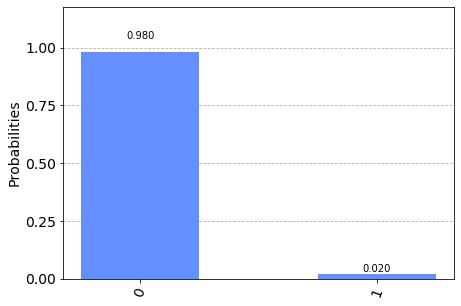

In [75]:
counts = results.get_counts(new_circ)
plot_histogram(counts)

In [64]:
qcirc.draw()

┌───────┐┌───────────┐┌─┐
q_0: ─────┤0      ├┤0          ├┤M├
          │       ││           │└╥┘
q_1: ─────┤1      ├┤1          ├─╫─
     ┌───┐│  B_dg ││  U+_SFFFT │ ║ 
q_2: ┤ X ├┤2      ├┤2          ├─╫─
     ├───┤│       ││           │ ║ 
q_3: ┤ X ├┤3      ├┤3          ├─╫─
     └───┘└───────┘└───────────┘ ║ 
a_0: ────────────────────────────╫─
                                 ║ 
c_0: ════════════════════════════╩═

In [5]:
backend_sim = Aer.get_backend('qasm_simulator')
N=4
cr = ClassicalRegister(N,'c')
qr = QuantumRegister(N,'q')
qcirc = QuantumCircuit(qr,cr)
for i in range(int(N/2)):
    qcirc.x(2*i+1)
qubits = [i for i in range(N)]
qcirc.append(swapladder(qubits),qubits)
qcirc.append(FFFT(qubits),qubits)
qcirc.measure(qr,cr)
pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qcirc)
job_sim = execute(new_circ, backend_sim, shots=1000)
results = job_sim.result()

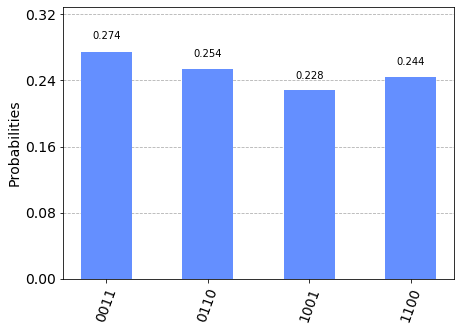

In [6]:
counts = results.get_counts(new_circ)
plot_histogram(counts)

In [7]:
np.fft.fft([0,1,0,1])

array([ 2.+0.j,  0.+0.j, -2.+0.j,  0.+0.j])